### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [9]:
import sys  
sys.path.insert(0, '../')

import HPO
import pysgpp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os
import math
from matplotlib import cm
import matplotlib 

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 0

SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Model creation function

In [10]:
def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()

    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation='relu'))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Hyperparameter space

In [11]:
hyperparameterspace = {
    'epochs': ["interval-int", 1, 40],
    'batch_size': ["interval-int", 1, 200],
    'learning rate': ["interval-log", 1e-10, 1e-1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

### Optimization

Adaptive grid generation (Ritter-Novak)...
Done in 16043ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done in 0ms.
Optimizing (adaptive Newton)...
Done in 0ms.
Optimizing (BFGS)...
Done in 0ms.
Optimizing (differential evolution)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Optimizing (multi-start)...
Done in 0ms.
Optimizing (NLCG)...
Done in 0ms.
Optimizing (Nelder-Mead)...
Done in 0ms.
Optimizing (Newton)...
Done in 0ms.
Optimizing (Rprop)...
Done in 0ms.
0
{(1,0.7871512770652771)}
1
{(1,0.8723803758621216)}
2
{(1,0.8723803758621216)}
3
{(1,0.8723803758621216)}
4
{(1,0.8860596418380737)}
5
{(1,0.8723803758621216)}
6
{(1,0.8718813359737396)}
7
{(1,0.8723803758621216)}
8
{(1,0.8723803758621216)}
9
{(1,0.8723803758621216)}
10
{(1,0.8723803758621216)}
Adaptive grid generation (Ritter-Novak)...
Done in 117559ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (adaptive gradient descent)...
Done i

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

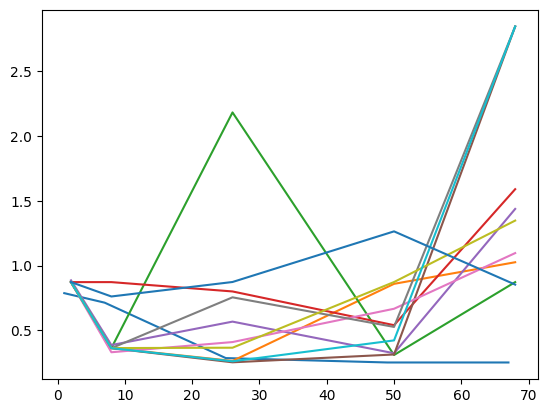

In [12]:

################## MODEL AND FUNCTION DEFINITION ####################
CV = 2
dataset = HPO.Dataset(task_id=233211)

def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=True):

    kfold = KFold(n_splits=CV)

    split = (kfold.split(dataset.get_X(), dataset.get_Y()))

    values = []

    numeric_features = [not x for x in dataset.get_categorical_indicator()]
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(
                handle_unknown="infrequent_if_exist", sparse_output=False)),
            # ("selector", SelectPercentile(chi2, percentile=50)),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer,
                dataset.get_categorical_indicator()),
        ]
    )

    for i, (train_index, test_index) in enumerate(split):

        if deterministic:
            reset_seeds()

        X_train = dataset.get_X()[train_index]
        Y_train = dataset.get_Y()[train_index]

        X_val = dataset.get_X()[test_index]
        Y_val = dataset.get_Y()[test_index]

        preprocessor.fit(X_train, Y_train)

        X_train = preprocessor.transform(X_train)
        X_val = preprocessor.transform(X_val)

        regressor = KerasRegressor(model=create_model,
                                    learning_rate=learning_rate,
                                    input_dim=len(
                                        X_train[0]),
                                    number_layers=number_of_layers,
                                    neurons_per_layer=neurons_per_layer,
                                    verbose=0)

        regressor = TransformedTargetRegressor(regressor=regressor,
                                                transformer=StandardScaler())

        regressor.fit(X_train, Y_train, epochs=int(epochs),
                        batch_size=int(batch_size), shuffle=False)

        Y_predicted = regressor.predict(X_val)
        # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
        error = sklearn.metrics.mean_absolute_percentage_error(
            Y_predicted, Y_val)
        values.append(error)

        del regressor
        K.clear_session()

    result = sum(values)/len(values)
    return result



class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(
            len(hyperparameterspace.keys()))

    def eval(self, x):
        epochs = int(HPO.from_standard(
            hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

        batch_size = int(HPO.from_standard(
            hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

        model_learning_rate = HPO.from_standard_log(
            hyperparameterspace_special["learning rate"][0], hyperparameterspace_special["learning rate"][1], x[2])

        number_of_layers = 1

        neurons_per_layer = 30

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

BUDGETS = [5, 10, 30, 50, 70]

RESULTS = [[], [], [], [], [], [], [], [], [], [], [], []]
RESULT_STRINGS = ["{", "{", "{", "{", "{", "{", "{", "{", "{", "{", "{", "{"]
COSTS = [[], []]

for budget in BUDGETS:

    optimizer = HPO.SparseGridSearchOptimization(dataset, ExampleFunction(), hyperparameterspace, budget, verbosity=0, degree=2, adaptivity=0.85)
    result, cost = optimizer.fit()

    for i in range(11):
        RESULTS[i].append(result[i])
        RESULT_STRINGS[i] += "(" + str(cost) + "," + str(result[i]) + ")"

    COSTS[0].append(cost)
    COSTS[1].append(cost + 1)


    for i in range(11):
        print(i)
        print(RESULT_STRINGS[i]+"}")

        
optimizer_names = ["adaptive_gradient_descent","adaptive_newton","bfgs","cmaes","differential_evolution","gradient_descent","multi start","nlcg","nelder_mead","newton","rprop"]

plt.plot(COSTS[0], RESULTS[0], label="without")
for i in range(11):
    plt.plot(COSTS[1], RESULTS[i+1], label=optimizer_names[i])

# naming the x axis
plt.xlabel('Cost')
# naming the y axis
plt.ylabel('Result')

# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()


